#The Protein Network Graph to Find Bounding Aminoacids using Variational Quantum Circuits.

# Variational Quantum Circuits in a Protein Network Graph.

# Objetives

* To find bounding amino acids function on a delimited network graph approach that characterized a chemical structure using a variational quantum circuit.
* To apply quantum circuits used in graph theory and optimization problems to map 3D-protein structure into chemical interaction network.
* Using the QAOA variational form to find an approximate solution for the protein folding quadratic program.
* To encourage people to push into quantum computing and solve real molecular biology problems faster than classical methods.



## Introduction. Protein Interactions

The main idea of the proposal es to mapp biochemical interactions inside a 3D-protein structure into a graph network. Therefore each edge will correspond to one of the following chemical interactions of the structure:

*   Hydrophobic 
*   Disulfide (bridnge) 
*   Hydrogen bonds
*   Ionic and aromatic (partial)
*   Cation- $\pi$
*   Peptide bond

On the other hand, nodes will correspond to each amino acid in the .pdb protein file. This file is preprocessed previously (order and prepare the data to be read). We extract the main graph from the PDB (protein database) file and delimit it with a few nodes; after this, we will implement a variational quantum circuit to find the function that maximizes the chemical bounding amino acids representation.



## Optimization Problem




In this case, we use a small macromolecule 1PLX (the crystal structure obtained by NMR of Methionine-Enkephalin in fast tumbling Bicelles/DMPG), with 5 amino acids (nodes) within just one chain (A).

To handle the information of the pdb file and for using the quantum qiskit libraries, the installation of the packages is as follows:


In [1]:
!pip install qiskit
!pip install biopandas
!pip install proteingraph 
!pip install qiskit-optimization
!pip install biopython


     |████████████████████████████████| 6.1 MB 2.4 MB/s 
     |████████████████████████████████| 17.9 MB 117 kB/s 
     |████████████████████████████████| 237 kB 54.0 MB/s 
     |████████████████████████████████| 207 kB 47.5 MB/s 
     |████████████████████████████████| 2.1 MB 47.6 MB/s 
     |████████████████████████████████| 634 kB 40.5 MB/s 
     |████████████████████████████████| 1.4 MB 57.4 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
     |████████████████████████████████| 943 kB 40.1 MB/s 
     |████████████████████████████████| 49 kB 8.5 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 3.5 MB 59 kB/s 
     |████████████████████████████████| 6.3 MB 46.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.0-py3-none-any.whl size=11773 sha256=c886424c9b9cfb06d665578330860fd2908c47352985a5e57b2c2c4395d57d4f
  Stored in directory: /root/.cache/pip/wheels/95/84/c4/6a084a33c1909266fca66eed2303c3883e03f33c905b1eb

In [2]:
import qiskit
qiskit.__version__

'0.18.3'

Importing the libraries needed

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from typing import List, Callable
from biopandas.pdb import PandasPdb

from qiskit import BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms.optimizers import SPSA ,COBYLA, SLSQP, ADAM
from qiskit.optimization.applications.ising import tsp
from qiskit.aqua import QuantumInstance
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import qiskit as qk
# Loading your IBM Quantum account(s)
qk.IBMQ.save_account('') #Replace the text my_token for your own token
provider = IBMQ.load_account()

from networkx.drawing.nx_pydot import write_dot
from collections import defaultdict
from functools import partial
from itertools import combinations
from pathlib import Path
import xarray as xr

from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean, pdist, rogerstanimoto, squareform
from proteingraph.resi_atoms import AA_RING_ATOMS,AROMATIC_RESIS,BACKBONE_ATOMS,BOND_TYPES
from proteingraph.resi_atoms import CATION_PI_RESIS,CATION_RESIS,DISULFIDE_ATOMS
from proteingraph.resi_atoms import DISULFIDE_RESIS, HYDROPHOBIC_RESIS,IONIC_RESIS
from proteingraph.resi_atoms import ISOELECTRIC_POINTS_STD, MOLECULAR_WEIGHTS_STD, NEG_AA
from proteingraph.resi_atoms import PI_RESIS, POS_AA, RESI_NAMES

from proteingraph.pin import compute_rgroup_dataframe
from proteingraph.pin import convert_all_sets_to_lists
from proteingraph.pin import pdb2df
from proteingraph.pin import compute_chain_pos_aa_mapping
from proteingraph.pin import filter_dataframe
from proteingraph.pin import add_aromatic_interactions
from proteingraph.pin import add_aromatic_sulphur_interactions
from proteingraph.pin import add_cation_pi_interactions
from proteingraph.pin import get_interacting_atoms
from proteingraph.pin import node_coords
from proteingraph.pin import add_interacting_resis


from Bio.PDB.vectors import rotaxis2m
from Bio.PDB.vectors import Vector
from qiskit_optimization.applications import Maxcut, Tsp


configrc.store_credentials:WARNING:2021-11-18 04:13:40,778: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-11-18 04:13:41,363: Credentials are already in use. The existing account in the session will be replaced.


W can use proteingraph methods to map the protein pdb file into a network interactios (using inside bopandas data structure), once we load the file.

A function of energy will be used to cluster the interactions between the amino acids. In this case, a chemical graph can represent these interactions. The edges of this graph are weighted using a energy function:

\begin{equation}
 E_{total \ potential}=E_{structure}+E_{bonding}
\end{equation}

where $E_{structure}$ corresponds to torsion angles formed by the torsion angles and $E_{bonding}$ is defined as (A newforce field (ECEPP-05) for peptides, proteins, and organicmolecules, 2006):

\begin{equation}
 E_{bonding}= \sum_{i=0}^{n} \sum_{j>i}^{n} \left(- \frac{ A_{ij}}{r_{ij}^{6}}+  \frac{B_{ij} e^{-C_{ij} r_{ij} } }{k_{1}} \right) + \sum_{i=0}^{n} \sum_{j>i}^{n} \frac{332 q_{i}q_{j}}{k_{2} \epsilon  r_{ij}}
\end{equation}

witn $n$ number of atoms, $A,B,C$ the non-bonded parameters, $r_{ij}$ the distances between atom $i$ and $j$ respectively; $k_{1}$ and $k_{2}$ are scaled factors, $q_{i}$ and $q_{j}$ are the point atomic charges and $\epsilon$ is the dielectric constant. 

The next methods are modified from proteingraph 0.3.0 (MIT License (MIT), Eric J. Ma*) open-source package, and are used to assign the chemical bonds between amino acids


* https://pypi.org/project/proteingraph/

In [4]:
def add_hydrogen_bond_interactions(G, rgroup_df):
    """Add all hydrogen-bond interactions."""
    # For these atoms, find those that are within 3.5A of one another.
    HBOND_ATOMS = ["ND",  # histidine and asparagine
        "NE",  # glutamate, tryptophan, arginine, histidine
        "NH",  # arginine
        "NZ",  # lysine
        "OD1",
        "OD2",
        "OE",
        "OG",
        "OH",
        "SD",  # cysteine
        "SG",  # methionine
        "N","O"]
    hbond_df = filter_dataframe(rgroup_df, "atom_name", HBOND_ATOMS, True)
    distmat = compute_distmat(hbond_df)
    interacting_atoms = get_interacting_atoms(3.5, distmat)
    add_interacting_resis(G, interacting_atoms, hbond_df, ["hbond"])
    # For these atoms, find those that are within 4.0A of one another.
    HBOND_ATOMS_SULPHUR = ["SD", "SG"]
    hbond_df = filter_dataframe(
        rgroup_df, "atom_name", HBOND_ATOMS_SULPHUR, True)
    distmat = compute_distmat(hbond_df)
    interacting_atoms = get_interacting_atoms(4.0, distmat)
    add_interacting_resis(G, interacting_atoms, hbond_df, ["hbond"])

def add_disulfide_interactions(G, rgroup_df):
    """
    Find all disulfide interactions between CYS residues.
    Criteria: sulfur atom pairs are within 2.2A of each other.
    """
    disulfide_df = filter_dataframe(
        rgroup_df, "residue_name", DISULFIDE_RESIS, True)
    disulfide_df = filter_dataframe(
        disulfide_df, "atom_name", DISULFIDE_ATOMS, True)
    distmat = compute_distmat(disulfide_df)
   # print("head disulfide")
   # print(disulfide_df.columns)
    if disulfide_df.empty:
     print("DataFrame is empty!")
    else:
     interacting_atoms = get_interacting_atoms(2.2, distmat)
     add_interacting_resis(G, interacting_atoms, disulfide_df, ["disulfide"])


def add_ionic_interactions(G, rgroup_df):
    """
    Find all ionic interactions.
    Criteria: ARG, LYS, HIS, ASP, and GLU residues are within 6A.
    """
    ionic_df = filter_dataframe(rgroup_df, "residue_name", IONIC_RESIS, True)
    if ionic_df.empty:
     print("DataFrame is empty!")
    else:
     distmat = compute_distmat(ionic_df)
     interacting_atoms = get_interacting_atoms(6, distmat)
     add_interacting_resis(G, interacting_atoms, ionic_df, ["ionic"])
    # Check that the interacting residues are of opposite charges
     for r1, r2 in get_edges_by_bond_type(G, "ionic"):
         condition1 = (G.nodes[r1]["residue_name"] in POS_AA
             and G.nodes[r2]["residue_name"] in NEG_AA)
         condition2 = (G.nodes[r2]["residue_name"] in POS_AA
             and G.nodes[r1]["residue_name"] in NEG_AA)
         is_ionic = condition1 or condition2
         if not is_ionic:
             G.edges[r1, r2]["kind"].remove("ionic")
             if len(G.edges[r1, r2]["kind"]) == 0:
                 G.remove_edge(r1, r2)

def compute_distmat(pdb_df):
    """
    Compute pairwise euclidean distances between every atom.
    Design choice: passed in a DataFrame to enable easier testing on
    dummy data.
    """
    pp=squareform(pdist(pdb_df[["x_coord","y_coord", "z_coord"]]))
    print("y pp es")
    print(pp)
    eucl_dists = pd.DataFrame(pp)
    if pdb_df.empty:
     print("DataFrame is empty!")
    else:
     eucl_dists.index = pdb_df.index
     eucl_dists.columns = pdb_df.index
    return eucl_dists

In [7]:
def add_hydrophobic_interactions(G, rgroup_df):
    """
    Find all hydrophobic interactions.
    Performs searches between the following residues:
    ALA, VAL, LEU, ILE, MET, PHE, TRP, PRO, TYR
    Criteria: R-group residues are within 5A distance.
    """
    hydrophobics_df = filter_dataframe(rgroup_df,
    "residue_name", HYDROPHOBIC_RESIS, True)
    distmat = compute_distmat(hydrophobics_df)
    interacting_atoms = get_interacting_atoms(5, distmat)
    print("interacting hidro")
    add_interacting_resis(G, interacting_atoms,
    hydrophobics_df, ["hydrophobic"])

def compute_interaction_graph(pdb_df, chain_pos_aa, edge_funcs=None):
    """
    Compute the interaction graph.
    ## Parameters:
    - `pdb_df`: A pandas DataFrame.
        Should be the result of calling `pdb2df`.
    - `chain_pos_aa`: A nested dictionary mapping chain -> pos -> aa.
        Should be the result of calling `compute_chain_pos_aa_mapping`.
    - `edge_funcs`: Arbitrary functions which take in only a graph `G`,
        and uses `add_edge` to add edges to the graph.
    """
    G = nx.Graph()
    for g, d in pdb_df.query("record_name == 'ATOM'").groupby(
        ["node_id", "chain_id", "residue_number", "residue_name"]):
        node_id, chain_id, residue_number, residue_name = g
        x_coord = d.query("atom_name == 'CA'")["x_coord"].values[0]
        y_coord = d.query("atom_name == 'CA'")["y_coord"].values[0]
        z_coord = d.query("atom_name == 'CA'")["z_coord"].values[0]
        G.add_node(node_id, chain_id=chain_id,
            residue_number=residue_number,
            residue_name=residue_name,
            x_coord=x_coord,
            y_coord=y_coord,
            z_coord=z_coord,
            features=None)
    # Add in edges for amino acids that are adjacent in the linear amino
    # acid sequence.
    nx.draw_shell(G, with_labels=True, font_weight='bold')
    plt.show()
    for n, d in G.nodes(data=True):
        chain = d["chain_id"]
        pos = d["residue_number"]
        aa = d["residue_name"]
        if (pos-1) in chain_pos_aa[chain].keys():
            prev_aa = chain_pos_aa[chain][pos - 1]
            print("nodo previo")
            print(prev_aa)
            prev_node = f"{chain}{pos-1}{prev_aa}"
            print("quien es prev node")
            print(prev_node)
            if aa in RESI_NAMES and prev_aa in RESI_NAMES:
                G.add_edge(n, prev_node, kind={"backbone"})
        if (pos+1) in chain_pos_aa[chain].keys():
            print("pos posterior")
            print(pos+1)
            next_aa = chain_pos_aa[chain][pos + 1]
            next_node = f"{chain}{pos+1}{next_aa}"
            print("nodo posterior")
            print(next_node)
            if aa in RESI_NAMES and next_aa in RESI_NAMES:
                G.add_edge(n, next_node, kind={"backbone"})

    print("entro a las funciones")
    for func in edge_funcs:
        func(G)
    return G


In [8]:
def read_pdb(path: Path):
    """
    Parse PDB file into protein graph.
    Overall function to read PDB and get back graph.
    """
    pdb_df = pdb2df(path)
    rgroup_df = compute_rgroup_dataframe(pdb_df)
    chain_pos_aa = compute_chain_pos_aa_mapping(pdb_df)
    edge_funcs = [
        partial(add_hydrophobic_interactions, rgroup_df=rgroup_df),
        partial(add_disulfide_interactions, rgroup_df=rgroup_df),
        partial(add_hydrogen_bond_interactions, rgroup_df=rgroup_df),
        partial(add_ionic_interactions, rgroup_df=rgroup_df),
        partial(add_aromatic_interactions, pdb_df=pdb_df),
        partial(add_aromatic_sulphur_interactions, rgroup_df=rgroup_df),
        partial(add_cation_pi_interactions, rgroup_df=rgroup_df),]
    print("despues de partial")
    G = compute_interaction_graph(pdb_df, chain_pos_aa, edge_funcs=edge_funcs)
    convert_all_sets_to_lists(G)
    return G

First we get the node map that represent the amino acids as each node, then the edges are placed with the previous functions.

despues de partial


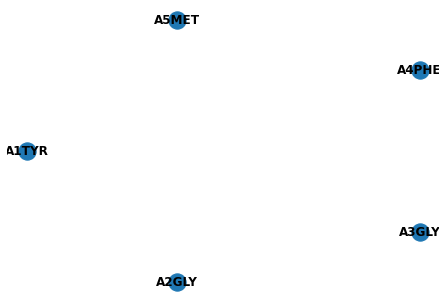

pos posterior
2
nodo posterior
A2GLY
nodo previo
TYR
quien es prev node
A1TYR
pos posterior
3
nodo posterior
A3GLY
nodo previo
GLY
quien es prev node
A2GLY
pos posterior
4
nodo posterior
A4PHE
nodo previo
GLY
quien es prev node
A3GLY
pos posterior
5
nodo posterior
A5MET
nodo previo
PHE
quien es prev node
A4PHE
entro a las funciones
y pp es
[[0.         1.51267743 2.5270922  ... 5.5549     4.49956231 5.92190805]
 [1.51267743 0.         1.38950711 ... 5.34745799 4.09821303 5.75185727]
 [2.5270922  1.38950711 0.         ... 4.23877164 3.04330577 4.79046637]
 ...
 [5.5549     5.34745799 4.23877164 ... 0.         1.7638903  1.76315541]
 [4.49956231 4.09821303 3.04330577 ... 1.7638903  0.         1.76441662]
 [5.92190805 5.75185727 4.79046637 ... 1.76315541 1.76441662 0.        ]]
interacting hidro
y pp es
[[0.]]
DataFrame is empty!
DataFrame is empty!
y pp es
[[0.         5.98978038]
 [5.98978038 0.        ]]
y pp es
[[0.]]
DataFrame is empty!


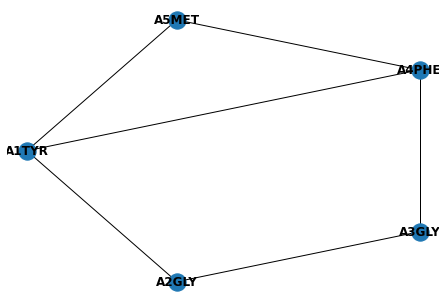

<Figure size 864x864 with 0 Axes>

In [9]:
p = read_pdb('1plxA.pdb')
nx.draw_shell(p, with_labels=True, font_weight='bold')
plt.figure(figsize=(12,12))
plt.show()

Then the weights are placed:

distance
 [[ 0 10  0 14  5]
 [10  0 10  0  0]
 [ 0 10  0 10  0]
 [14  0 10  0 15]
 [ 5  0  0 15  0]]


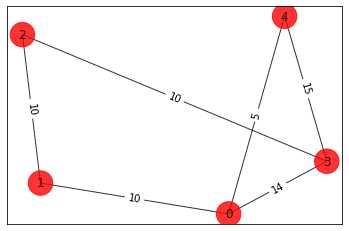

In [26]:

def draw_graph(T, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(T, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(T, 'weight')
    nx.draw_networkx_edge_labels(T, pos=pos, edge_labels=edge_labels)

T = nx.Graph()
T.add_nodes_from(np.arange(0,5,1))
n = 5
num_qubits = n ** 2
ins = tsp.random_tsp(n, seed=123)

#edges_with_weight =[
 #                   ('A1TYR', 'A2GLY' ,23),
  #                  ('A1TYR' ,'A5MET',22),
   #                 ('A1TYR' ,'A4PHE',18),
    #                ('A2GLY' ,'A3GLY', 12),
     #               ('A3GLY' ,'A4PHE',15),
      #              ('A4PHE' ,'A5MET',10)]

edges_with_weight =[(0, 1 ,10),
                    (0 ,4,5),
                    (0 ,3,14),
                    (1 ,2, 10),
                    (2 ,3,10),
                    (3 ,4,15)]
                    
T.add_weighted_edges_from(edges_with_weight)

colors = ['r' for node in T.nodes()]

weight_matrix = nx.adjacency_matrix(T).toarray()
size = weight_matrix.shape[0]
print('distance\n', weight_matrix)

pos = {k: v for k, v in enumerate(ins.coord)}
draw_graph(T, colors, pos)

Some extra-packages are impported

## Graph-reduction

Using the structure of the graph, we reduce the number of nodes to four in roder to get faster solution.



distance
 [[ 0 20 14  5]
 [20  0 20  0]
 [14 20  0 15]
 [ 5  0 15  0]]


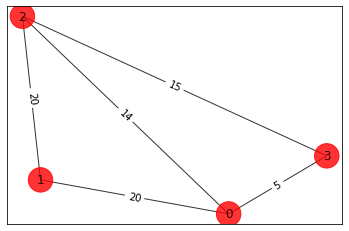

In [27]:
def draw_graph(T, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(T, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(T, 'weight')
    nx.draw_networkx_edge_labels(T, pos=pos, edge_labels=edge_labels)

O = nx.Graph()
O.add_nodes_from(np.arange(0,4,1))


n = 4
tsp = Tsp.create_random_instance(n, seed=123)
num_qubits = n ** 2
# ins = tsp.random_tsp(n, seed=123)


edges_with_weight =[(0, 1 ,20),
                    (0 ,2,14),
                    (0 ,3, 5),
                    (1 ,2,20),
                    (2 ,3,15)]

#G.add_weighted_edges_from([(1,2,1),(1,4,1),(3,4,1),(4,2,1)])                    
O.add_weighted_edges_from(edges_with_weight)

colors = ['r' for node in O.nodes()]

weight_matrix = nx.adjacency_matrix(O).toarray()
size = weight_matrix.shape[0]
print('distance\n', weight_matrix)

pos = {k: v for k, v in enumerate(ins.coord)}
draw_graph(O, colors, pos)

# Representation of the protein folding in a weight graph

The final four-node graph represents the clusterized biochemical-interaction network, where each node depicts an amino acid group within the whole protein structure. Each edge weight summarizes the assessment of the chemical interaction function between these groups od amino acids (nodes).

# Brute force approach

order = (0, 1, 2, 3) Weight of protein folding = 60
Best order from brute force = (0, 1, 2, 3) with total weight = 60


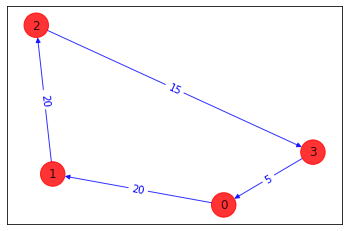

In [12]:
from itertools import permutations

def brute_force_pf(w, N):
    """Solves the best weight proteing folding path from weight and Nodes in the graph.
    Args:
        w: Weight matrix from the Graph.
        N: Number of nodes from the Graph.
    Returns:
        last_best_distance, Weight of totqal protein folding
    """
    a=list(permutations(range(1,N)))
    last_best_distance = 0
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance > last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Weight of protein folding = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_pf(weight_matrix, size)
print('Best order from brute force = ' + str(best_order) + ' with total weight = ' + str(best_distance))

def draw_pf_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_pf_solution(O, best_order, colors, pos)

# Protein interaction problem to QUBO (Quadratic Unconstrained Binary Optimization)

Base on the travelling sales man, we implement the cost function in order to solve the problem of found the most interacting amino acids withing a protein structure in functon of the weights of the final clustered graph, in this case we adequate the problem to maximize the cost function and get the best weight distance (function of protein structure).
 
\begin{equation}
C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,
\end{equation}

Protein folding as a Quadratic Program

We can reformulate it in the standard form for quadratic programs as written below.
$$
\begin{align}
\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1} + A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2 &= \sum_{i,j}\sum_{p} x_{i,p} w_{ij} x_{j,p+1} + A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2  \\
&= A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2 + \sum_{i,j}\sum_{p} x_{i,p} w_{ij} x_{j,p+1} \\
&= c^T x + x^T Q x, \\
\end{align}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = W_{ij} \qquad c_i = \sum_{i=1}^n i.
$$


We obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of that form is also called a quadratic unconstrained binary optimization instance, or QUBO for short.

In [28]:
qp = tsp.to_quadratic_program()

shape = weight_matrix.shape
size = shape[0]
    #Build qubo matrix Q from weight matrix W
qubo_matrix = np.zeros((size, size))
qubo_vector = np.zeros(size)
for i in range(size):
  for j in range(size):
    qubo_matrix[i, j] = weight_matrix[i, j]
for i in range(size):
  for j in range(size):
    qubo_vector[i] += i
qp.maximize(quadratic = qubo_matrix,linear = qubo_vector)#, linear = qubo_vector

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Maximize
 obj: 4 x_0_1 + 8 x_0_2 + 12 x_0_3 + [ 80 x_0_0*x_0_1 + 56 x_0_0*x_0_2
      + 20 x_0_0*x_0_3 + 80 x_0_1*x_0_2 + 60 x_0_2*x_0_3 ]/2
Subject To
 c0: x_0_0 + x_0_1 + x_0_2 + x_0_3 = 1
 c1: x_1_0 + x_1_1 + x_1_2 + x_1_3 = 1
 c2: x_2_0 + x_2_1 + x_2_2 + x_2_3 = 1
 c3: x_3_0 + x_3_1 + x_3_2 + x_3_3 = 1
 c4: x_0_0 + x_1_0 + x_2_0 + x_3_0 = 1
 c5: x_0_1 + x_1_1 + x_2_1 + x_3_1 = 1
 c6: x_0_2 + x_1_2 + x_2_2 + x_3_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 + x_3_3 = 1

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_2 <= 1
 0 <= x_2_3 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_1 <= 1
 0 <= x_3_2 <= 1
 0 <= x_3_3 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_0_3 x_1_0 x_1_1 x_1_2 x_1_3 x_2_0 x_2_1 x_2_2 x_2_3 x_3_0
 x_3_1 x_3_2 x_3_3
End



Qiskit provides automatic conversion from a suitableQuadraticProgramto an Insing Hamiltonian, which then allows to leverage all theMinimumEigenSolver.

In [29]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(str(qubitOp))

Offset: 2719.0
Ising Hamiltonian:
-346.0 * ZIIIIIIIIIIIIIII
- 346.0 * IZIIIIIIIIIIIIII
+ 86.5 * ZZIIIIIIIIIIIIII
- 346.0 * IIZIIIIIIIIIIIII
+ 86.5 * ZIZIIIIIIIIIIIII
+ 86.5 * IZZIIIIIIIIIIIII
- 346.0 * IIIZIIIIIIIIIIII
+ 86.5 * ZIIZIIIIIIIIIIII
+ 86.5 * IZIZIIIIIIIIIIII
+ 86.5 * IIZZIIIIIIIIIIII
- 346.0 * IIIIZIIIIIIIIIII
+ 86.5 * ZIIIZIIIIIIIIIII
- 346.0 * IIIIIZIIIIIIIIII
+ 86.5 * IZIIIZIIIIIIIIII
+ 86.5 * IIIIZZIIIIIIIIII
- 346.0 * IIIIIIZIIIIIIIII
+ 86.5 * IIZIIIZIIIIIIIII
+ 86.5 * IIIIZIZIIIIIIIII
+ 86.5 * IIIIIZZIIIIIIIII
- 346.0 * IIIIIIIZIIIIIIII
+ 86.5 * IIIZIIIZIIIIIIII
+ 86.5 * IIIIZIIZIIIIIIII
+ 86.5 * IIIIIZIZIIIIIIII
+ 86.5 * IIIIIIZZIIIIIIII
- 346.0 * IIIIIIIIZIIIIIII
+ 86.5 * ZIIIIIIIZIIIIIII
+ 86.5 * IIIIZIIIZIIIIIII
- 346.0 * IIIIIIIIIZIIIIII
+ 86.5 * IZIIIIIIIZIIIIII
+ 86.5 * IIIIIZIIIZIIIIII
+ 86.5 * IIIIIIIIZZIIIIII
- 346.0 * IIIIIIIIIIZIIIII
+ 86.5 * IIZIIIIIIIZIIIII
+ 86.5 * IIIIIIZIIIZIIIII
+ 86.5 * IIIIIIIIZIZIIIII
+ 86.5 * IIIIIIIIIZZIIIII
- 346.0 * IIIIIIIIII

# Running on a Quantum Computer

In [30]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [24]:
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [31]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print('feasible:', qubo.is_feasible(x))
z = tsp.interpret(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, weight_matrix))

energy: -2417.052734375
time: 382.99938917160034
feasible: True
solution: [2, 3, 0, 1]
solution objective: 60.0
